In [2]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [3]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [4]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [5]:
library(ComplexHeatmap)

Warning message:
"package 'ComplexHeatmap' was built under R version 4.2.1"
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original fu

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [7]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [8]:
bpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_biocyc_pathways.txt')
bpath_df = read.csv(bpath_fname, sep='\t')

In [9]:
bpath_df = bpath_df %>% rename(gene_id = Accession.2) %>% 
    separate_longer_delim(Pathways.of.gene, delim  = ' // ') %>%
    separate_longer_delim(Ontology...pathway.type, delim  = ' // ')


In [10]:
tail(bpath_df)

,Gene.Name,Accession.1,Product,gene_id,Pathways.of.gene,Ontology...pathway.type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4223,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,"tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate","Cofactor, Carrier, and Vitamin Biosynthesis"
4224,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,"tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate",Nucleoside and Nucleotide Biosynthesis
4225,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,Superpathways
4226,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,"Cofactor, Carrier, and Vitamin Biosynthesis"
4227,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,Nucleoside and Nucleotide Biosynthesis
4228,mrdA,PMM0040,penicillin-binding protein 2,TX50_RS00215,peptidoglycan maturation (<i>meso</i>-diaminopimelate containing),Cell Structure Biosynthesis


In [11]:
hpath_df = hpath_df  %>% 
    extract(path, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(pathway = str_trim(pathway))

In [12]:
hpath_df = hpath_df %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 



In [13]:
hpath_df = hpath_df %>% 
    extract(ecpath, c("kegg_gene"), "^K[[:digit:]]+ *([^;]*);", remove = FALSE) 

In [14]:
hpath_df = hpath_df %>% 
    mutate(
        prev_gene = gene,
        gene = if_else(gene != '', gene, paste0('(',kegg_gene,')'))
        
    )

In [15]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";"),
         pathway = paste0(unique(pathway), collapse = ";"),
         module = paste0(unique(module), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

In [16]:
hpath_df %>% filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    #count(system)
    filter(is.na(system)) %>% distinct(ecpath)

ecpath
<chr>
K03110 ftsY; fused signal recognition particle receptor
"K18890 mdlB, smdB; ATP-binding cassette, subfamily B, multidrug efflux pump"
"K18889 mdlA, smdA; ATP-binding cassette, subfamily B, multidrug efflux pump"
"K03217 yidC, spoIIIJ, OXA1, ccfA; YidC/Oxa1 family membrane protein insertase"
"K03106 SRP54, ffh; signal recognition particle subunit SRP54 [EC:3.6.5.4]"


# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [17]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Rows: 24377 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): contrast, gene_id, Assay, contrast1
dbl (5): logFC, AveExpr, pvalue, padj, Length
lgl (2): down, up

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
df_all = left_join(df_all, hpath_df_to_export, by='gene_id')

In [19]:
goseq_res = read_csv(file.path('DE_results', 'MED4_GOSEQ_results.csv'))

Rows: 2486 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (13): category, PATH, pathway, main, Category, type, enrich, Assay, cont...
dbl  (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
head(goseq_res)

category,PATH,pathway,over_represented_pvalue,padj,under_represented_pvalue,numDEInCat,numInCat,main,Category,type,enrich,Assay,contrast,organism,sub,module,Group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
09122,09122 Translation,Translation,1.449809e-09,2.609655e-08,1.0000000,23,74,09120 Genetic Information Processing,Genetic,down,sub,prot,C2vsC1_prot,MED4,09122 Translation,Translation,Coculture
09109,09109 Metabolism of terpenoids and polyketides,Metabolism of terpenoids and polyketides,1.514088e-01,1.000000e+00,0.9480650,4,25,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,MED4,09109 Metabolism of terpenoids and polyketides,terpenoids and polyketides,Coculture
09102,09102 Energy metabolism,Energy metabolism,2.202984e-01,1.000000e+00,0.8678961,11,105,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,MED4,09102 Energy metabolism,Energy,Coculture
09145,09145 Cellular community - prokaryotes,Cellular community - prokaryotes,2.860677e-01,1.000000e+00,0.8900496,3,22,09140 Cellular Processes,Cellular,down,sub,prot,C2vsC1_prot,MED4,09145 Cellular community - prokaryotes,Cellular community - prokaryotes,Coculture
09103,09103 Lipid metabolism,Lipid metabolism,5.852261e-01,1.000000e+00,0.6993905,2,24,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,MED4,09103 Lipid metabolism,Lipid,Coculture
09132,09132 Signal transduction,Signal transduction,6.521043e-01,1.000000e+00,0.6295640,2,27,09130 Environmental Information Processing,Environmental,down,sub,prot,C2vsC1_prot,MED4,09132 Signal transduction,Signal transduction,Coculture


In [21]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

,Assay,Group
,<fct>,<fct>
C1vsP1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
LATEvsC1P1_rna,rna,Coculture
C2vsC1_prot,prot,Coculture
C3vsC1_prot,prot,Coculture
C4vsC1_prot,prot,Coculture


In [22]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [23]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [24]:
goseq_pal_updown_fun = colorRamp2(c(-6, log10(0.05), 0,-log10(0.05), 6), c('blue', 'lightblue', "white", 'pink', "red"))


In [249]:
goseq_pal_fc_fun = colorRamp2(c(-4,-2,-1, 0, 1,2, 4), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [250]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [251]:
t(tail(goseq_res))

category,00640,00660,00720,00770,00780,02026
PATH,00640 Propanoate metabolism [PATH:ko00640],00660 C5-Branched dibasic acid metabolism [PATH:ko00660],00720 Carbon fixation pathways in prokaryotes [PATH:ko00720],00770 Pantothenate and CoA biosynthesis [PATH:ko00770],00780 Biotin metabolism [PATH:ko00780],02026 Biofilm formation - Escherichia coli [PATH:ko02026]
pathway,Propanoate metabolism,C5-Branched dibasic acid metabolism,Carbon fixation pathways in prokaryotes,Pantothenate and CoA biosynthesis,Biotin metabolism,Biofilm formation - Escherichia coli
over_represented_pvalue,1,1,1,1,1,1
padj,1,1,1,1,1,1
under_represented_pvalue,0.3492322,0.5160745,0.1889980,0.1877376,0.3109126,0.4704914
numDEInCat,0,0,0,0,0,0
numInCat,7,5,11,13,10,6
main,09100 Metabolism,09100 Metabolism,09100 Metabolism,09100 Metabolism,09100 Metabolism,09140 Cellular Processes
Category,Metabolism,Metabolism,Metabolism,Metabolism,Metabolism,Cellular
type,up,up,up,up,up,up


In [252]:
goseq_res %>% 
    filter(module %in% module_list) %>%
    distinct(pathway, PATH, module)


pathway,PATH,module
<chr>,<chr>,<chr>
Metabolism of other amino acids,09106 Metabolism of other amino acids,other amino acids
Amino acid metabolism,09105 Amino acid metabolism,Amino acid
Cysteine and methionine metabolism,00270 Cysteine and methionine metabolism [PATH:ko00270],Amino acid
Selenocompound metabolism,00450 Selenocompound metabolism [PATH:ko00450],other amino acids
"Alanine, aspartate and glutamate metabolism","00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250]",Amino acid
"Phenylalanine, tyrosine and tryptophan biosynthesis","00400 Phenylalanine, tyrosine and tryptophan biosynthesis [PATH:ko00400]",Amino acid
"Glycine, serine and threonine metabolism","00260 Glycine, serine and threonine metabolism [PATH:ko00260]",Amino acid
Arginine biosynthesis,00220 Arginine biosynthesis [PATH:ko00220],Amino acid
"Valine, leucine and isoleucine biosynthesis","00290 Valine, leucine and isoleucine biosynthesis [PATH:ko00290]",Amino acid


Warning message in brewer.pal(length(unique(module_mat$module)), "Set3"):
"minimal value for n is 3, returning requested palette with 3 different levels
"


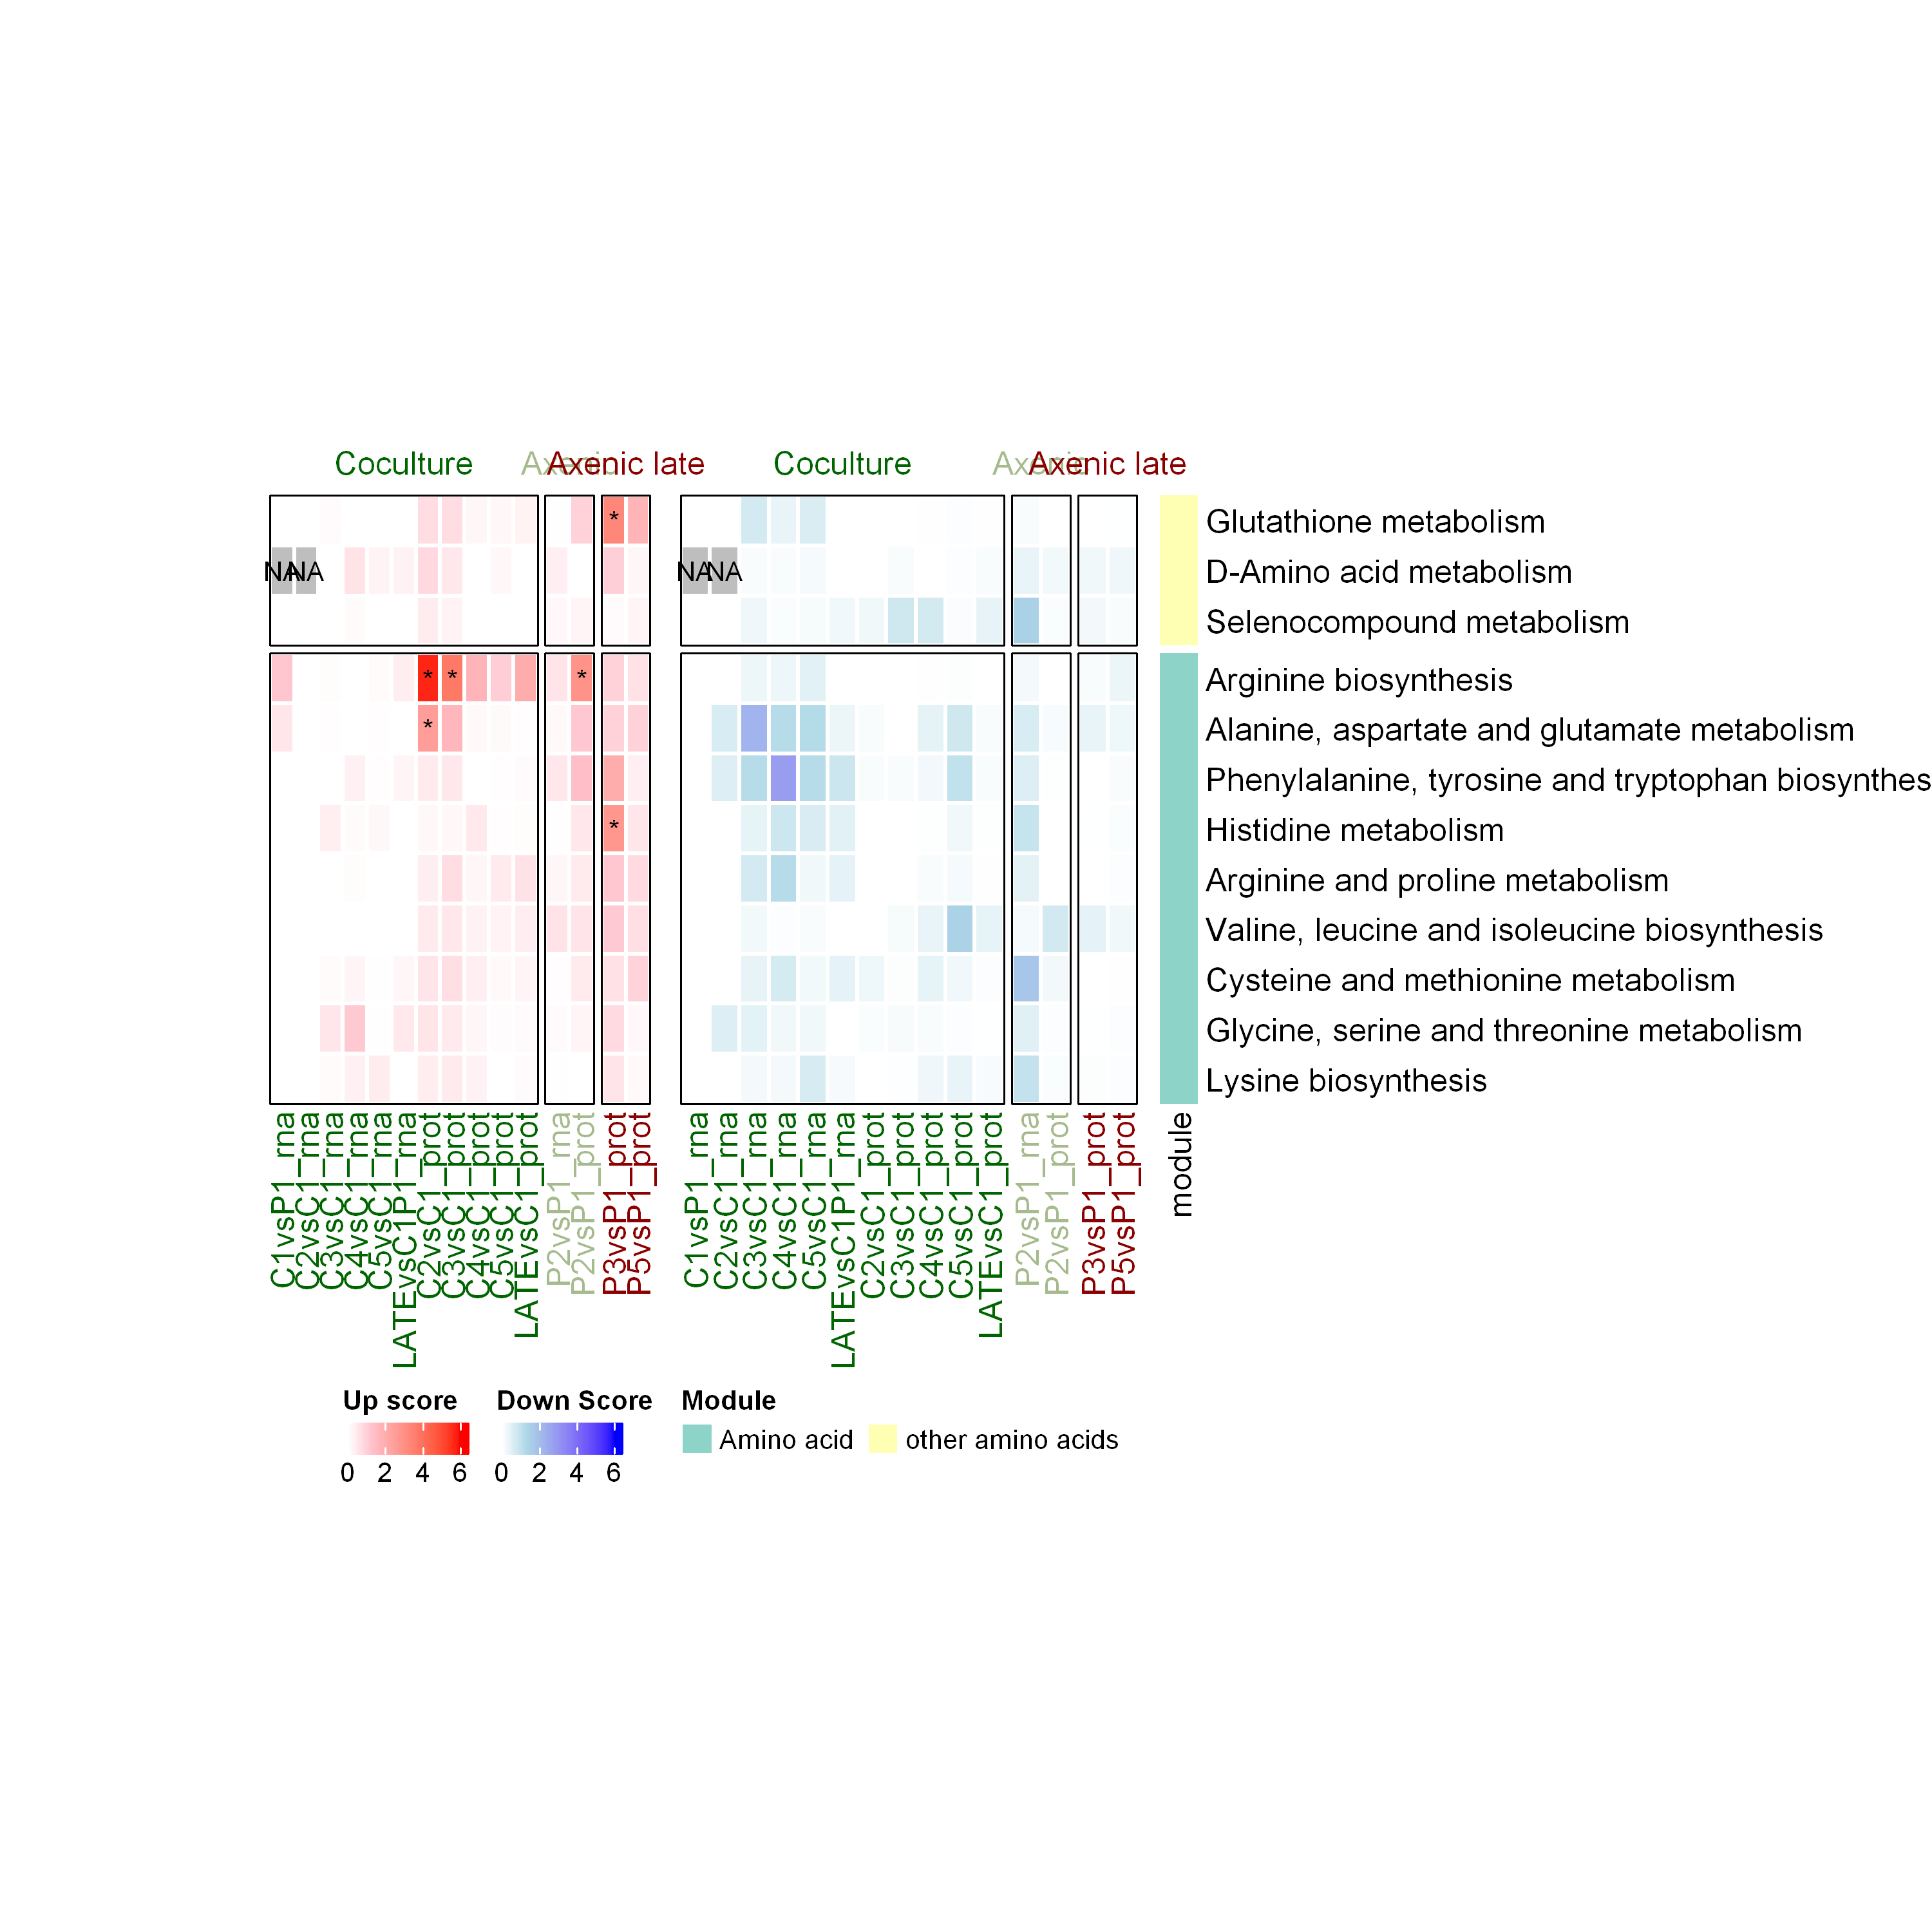

In [253]:
module_list = c('other amino acids', 'Amino acid')
toppaths = goseq_res %>% 
    filter(module %in% module_list, enrich %in% 'path') %>%
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(5, 'cm'),
    height=unit(8, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Down Score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

In [254]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Heatmap per Module

In [255]:
genome = 'MED4'

In [256]:
modules_de = goseq_res %>% 
    filter(padj < 0.05) %>% 
    count(module)



In [289]:
deg = df_all %>% filter(padj < 0.05) %>% distinct(gene_id)
hpath_df %>% 
    filter(gene_id %in% deg$gene_id, module %in% modules_de$module) %>% 
    distinct(gene_id, module) %>%
    count(module) %>% arrange(n)



module,n
<chr>,<int>
Lipid,25
other secondary metabolites,25
terpenoids and polyketides,25
other amino acids,30
Membrane transport,42
Nucleotide,55
Translation,78
Carbohydrate,88
Amino acid,108


## Membrane transport

In [290]:
module_name = 'Membrane transport'
module_title = paste0(genome, ' ',module_name)

In [291]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    distinct(pathway)

In [292]:
toppaths

pathway
<chr>
Membrane transport
Bacterial secretion system
ABC transporters


In [293]:
degenes = hpath_df %>% 
    filter(module %in% module_name
           ) %>% 
    distinct(gene_id)

In [294]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [295]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [296]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


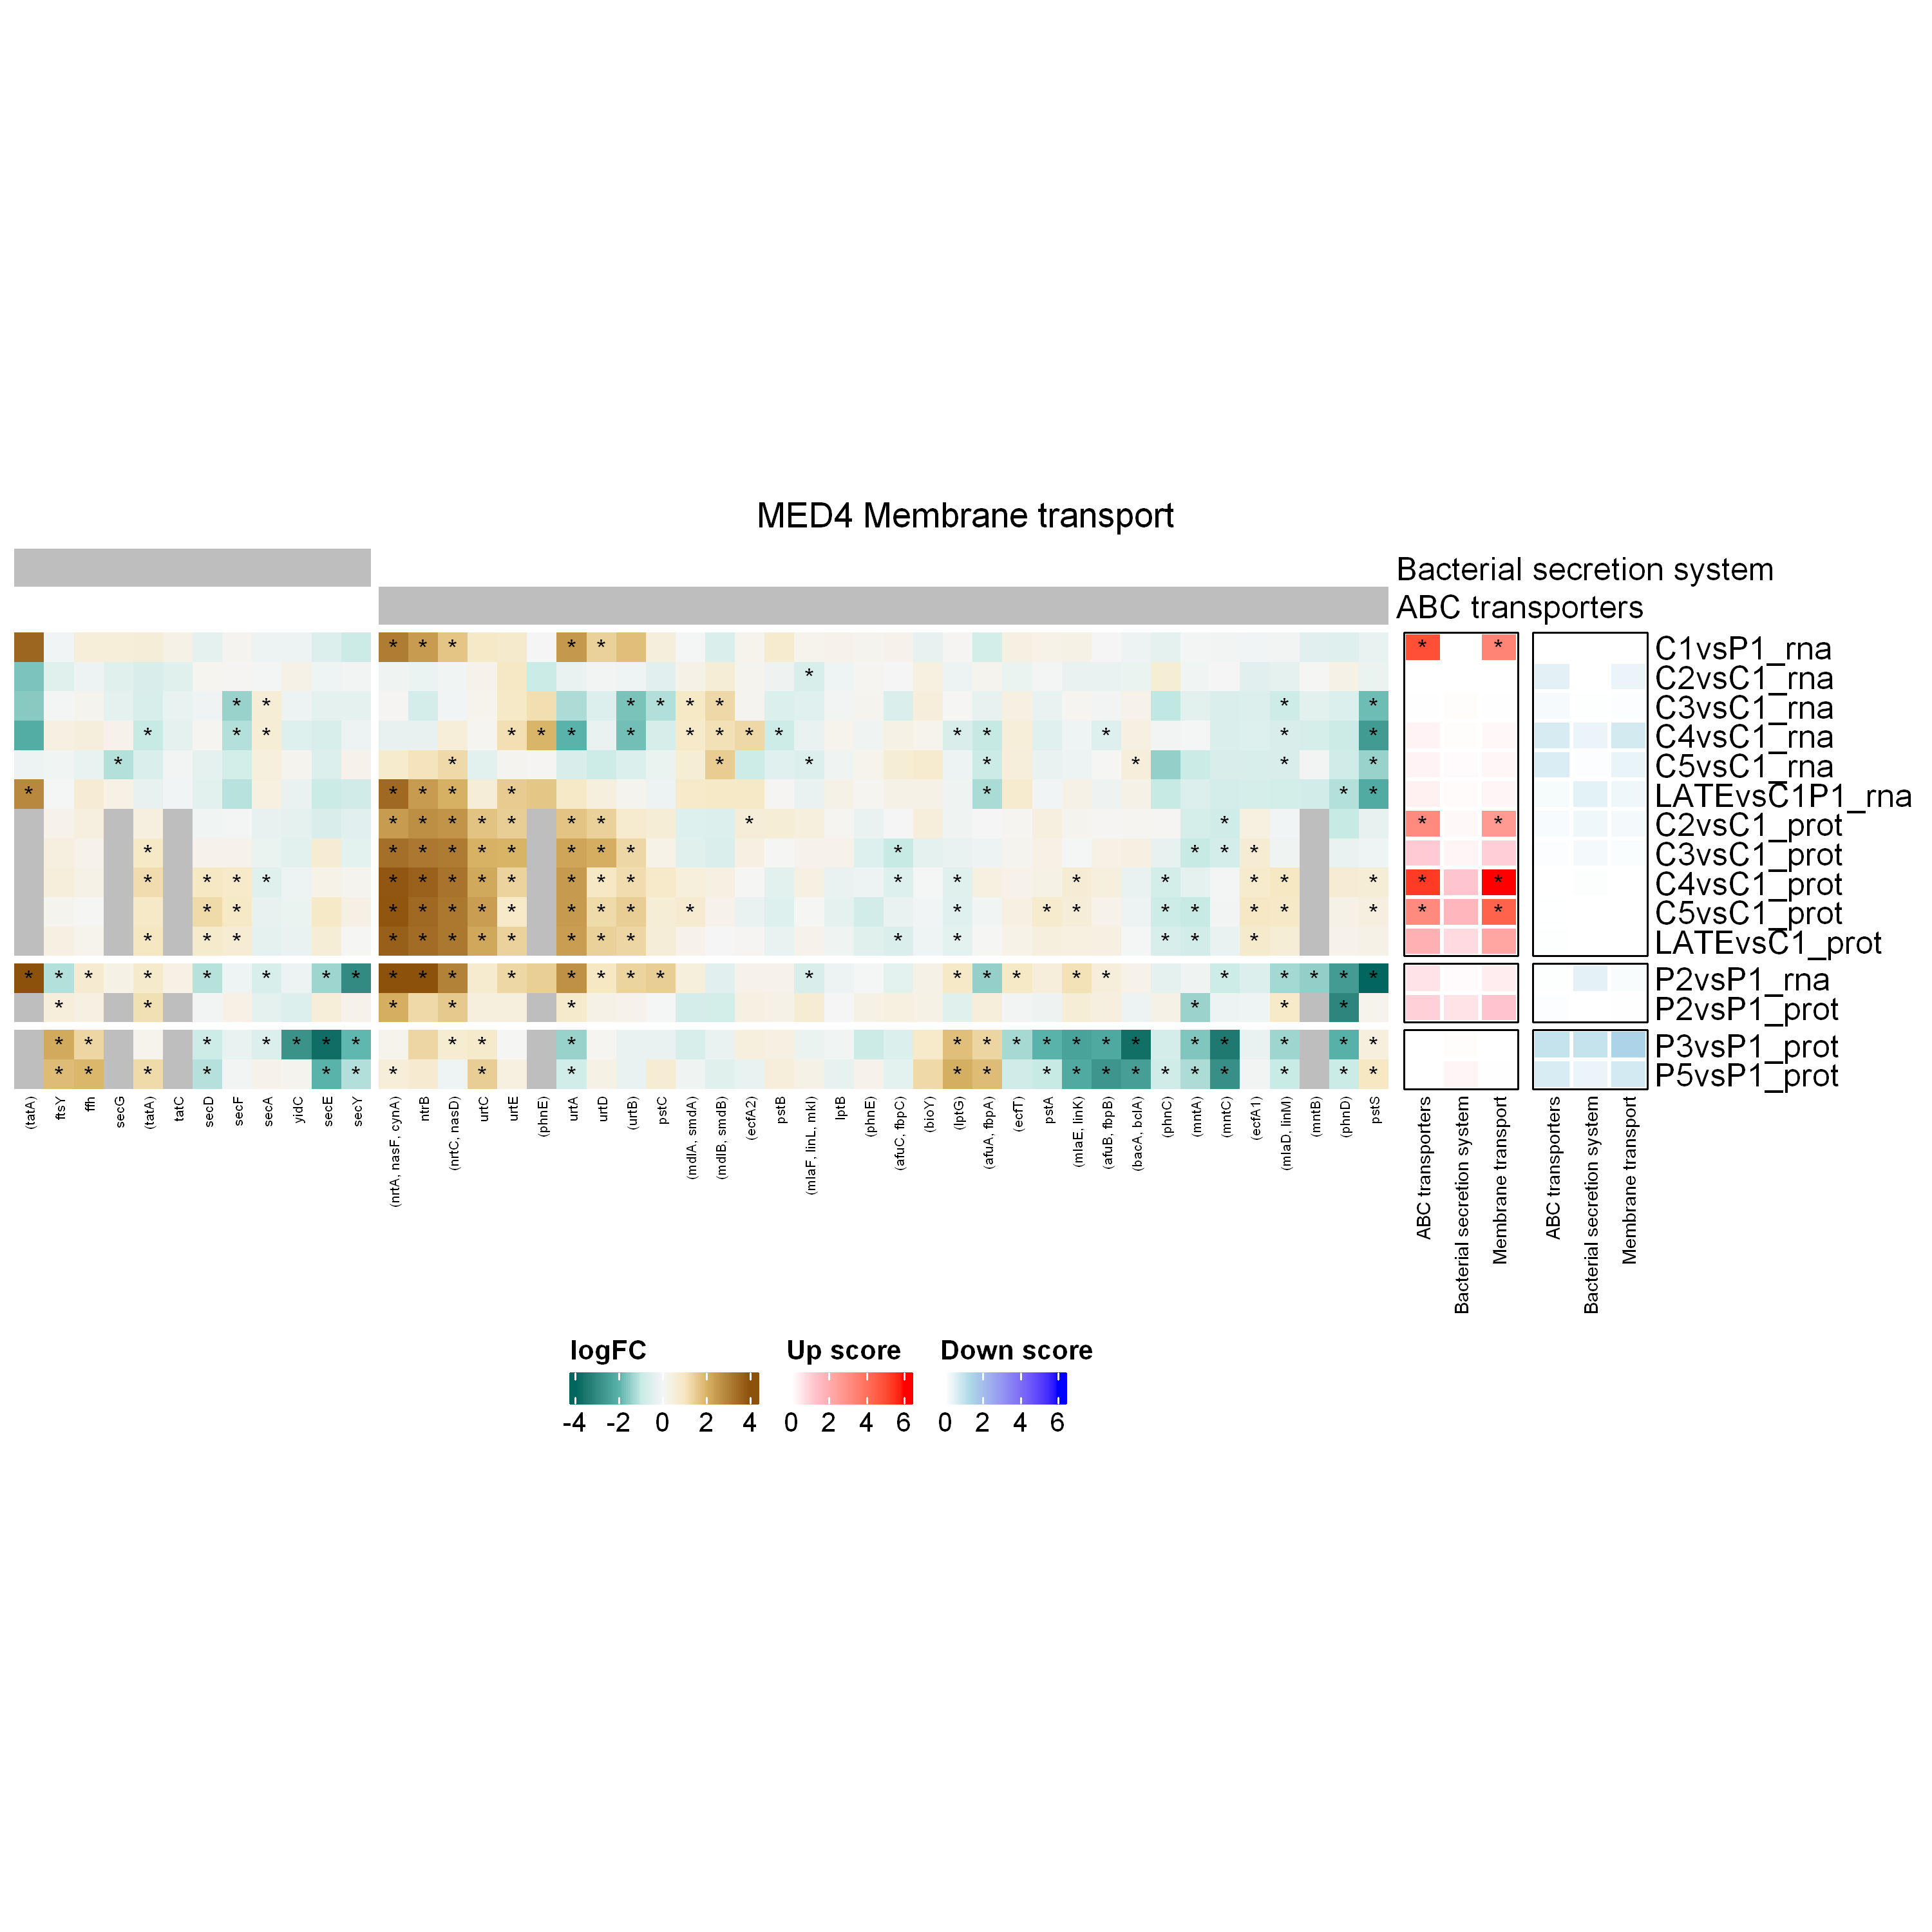

In [297]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other amino acids 

In [258]:
module_name = 'other amino acids'
module_title = paste0(genome, ' ',module_name)

In [259]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    distinct(pathway)

In [260]:
toppaths

pathway
<chr>
Metabolism of other amino acids
Selenocompound metabolism
D-Amino acid metabolism
Glutathione metabolism


In [261]:
degenes = hpath_df %>% 
    filter(module %in% module_name
           ) %>% 
    distinct(gene_id)

In [262]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [263]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [264]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


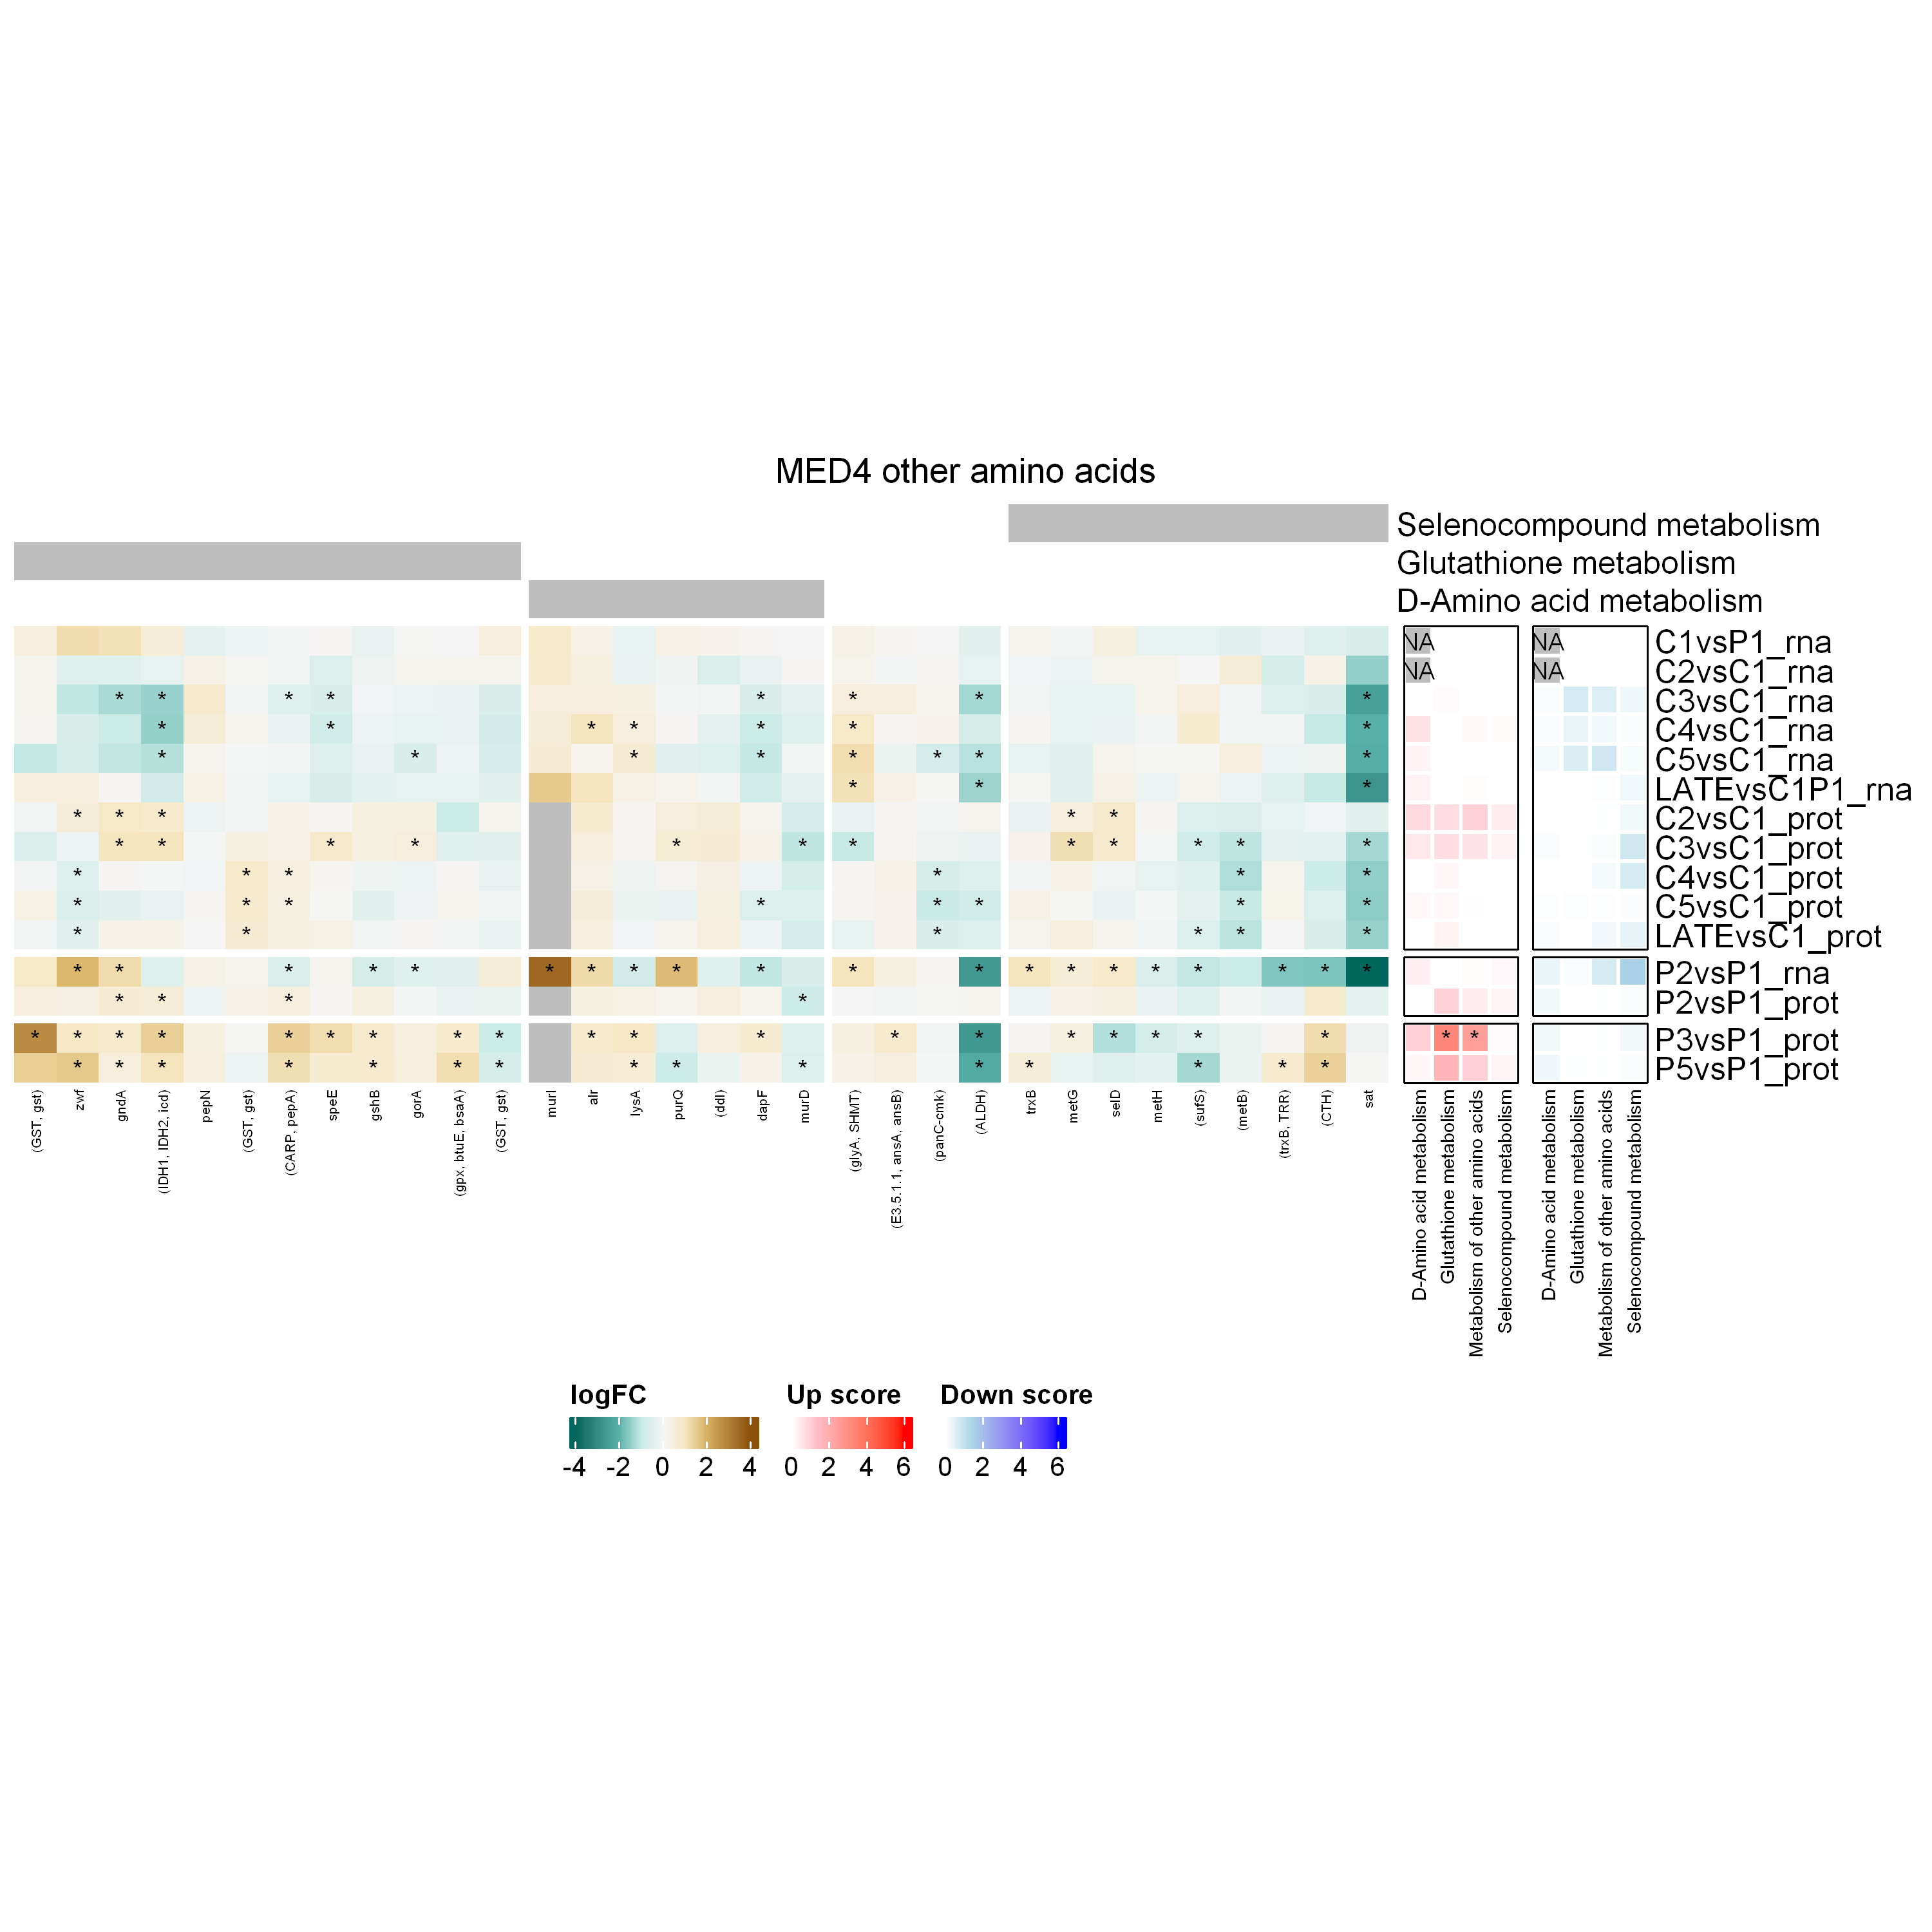

In [265]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid

In [266]:
aa_list_for_fig1 =  c(
"Alanine, aspartate and glutamate metabolism", "Phenylalanine, tyrosine and tryptophan biosynthesis", 
 "Arginine biosynthesis", 

"Arginine and proline metabolism")
                                                                           

In [267]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [268]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    filter(pathway %in% aa_list_for_fig1) %>% 
    distinct(pathway)

In [269]:
toppaths

pathway
<chr>
"Alanine, aspartate and glutamate metabolism"
"Phenylalanine, tyrosine and tryptophan biosynthesis"
Arginine biosynthesis
Arginine and proline metabolism


In [270]:
degenes = hpath_df %>% 
    filter(module %in% module_name, 
           pathway %in% aa_list_for_fig1 
           ) %>% 
    distinct(gene_id)

In [271]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [272]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [273]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


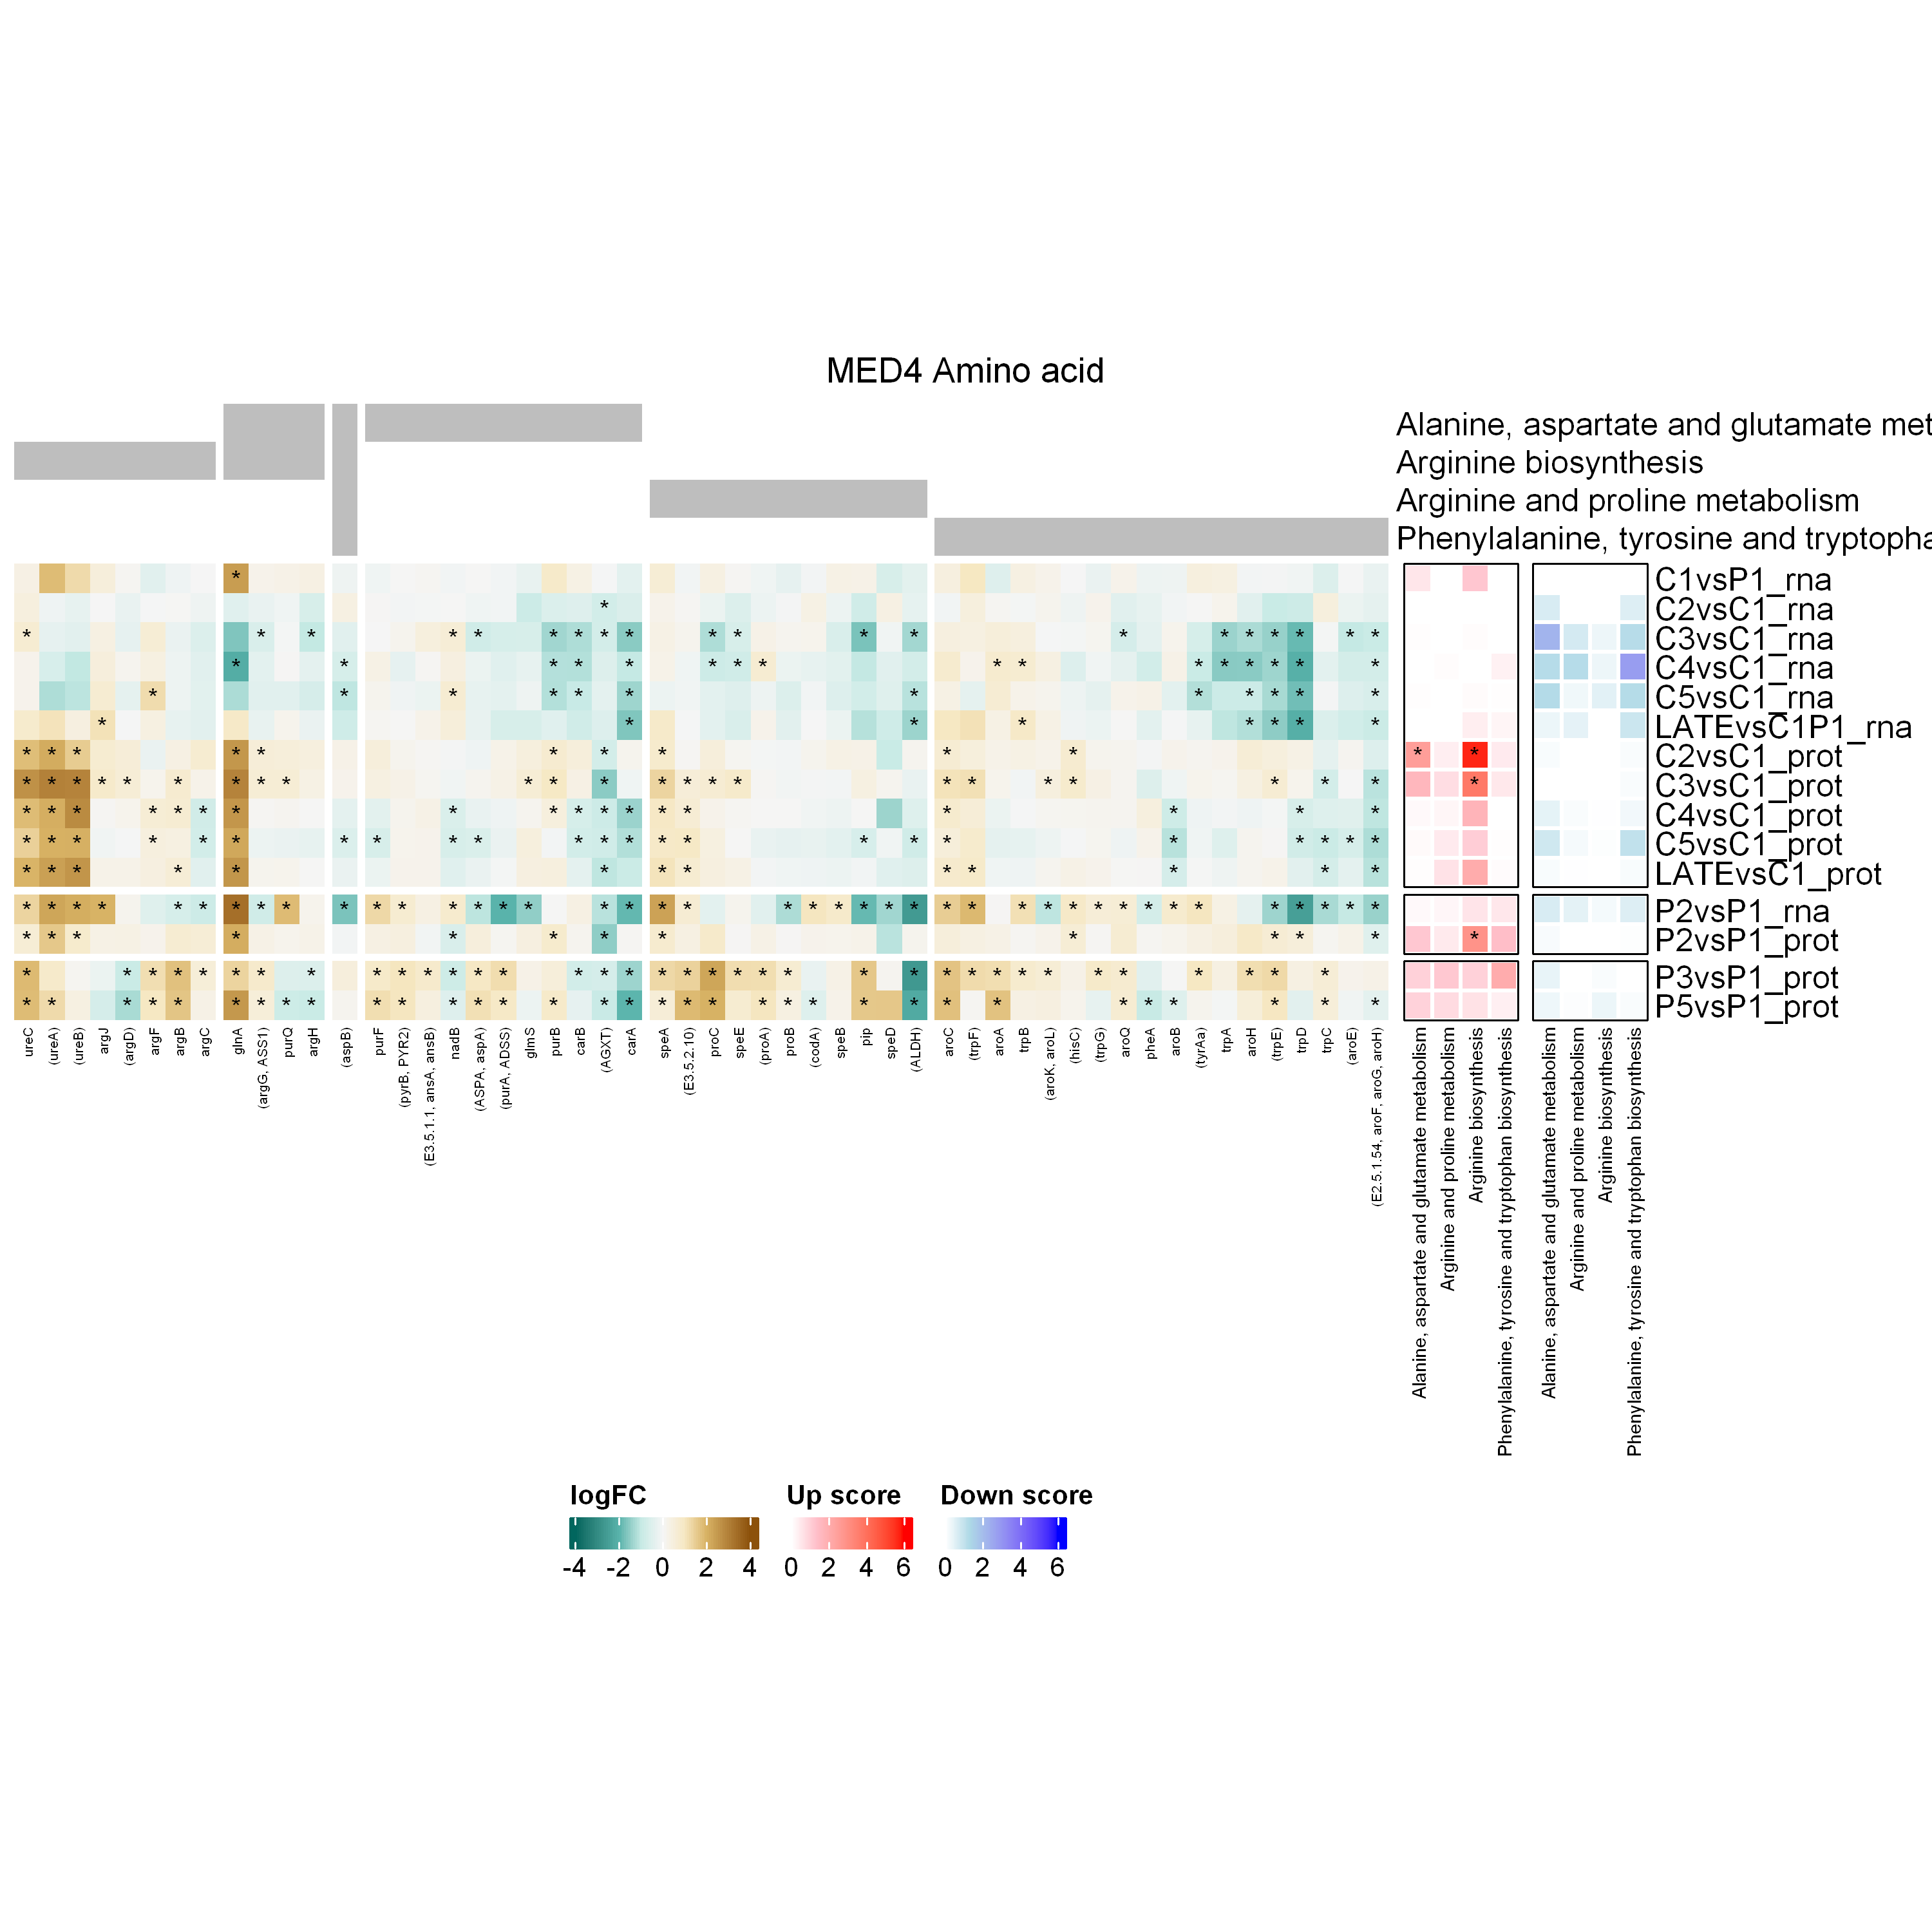

In [274]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid figure 2

In [275]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [276]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    filter(!(pathway %in% aa_list_for_fig1)) %>% 
    distinct(pathway)

In [277]:
toppaths

pathway
<chr>
Amino acid metabolism
Cysteine and methionine metabolism
"Glycine, serine and threonine metabolism"
"Valine, leucine and isoleucine biosynthesis"
Lysine biosynthesis
Histidine metabolism


In [278]:
degenes = hpath_df %>% 
    filter(module %in% module_name, 
           !(pathway %in% aa_list_for_fig1 )
           ) %>% 
    distinct(gene_id)

In [279]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [280]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [281]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


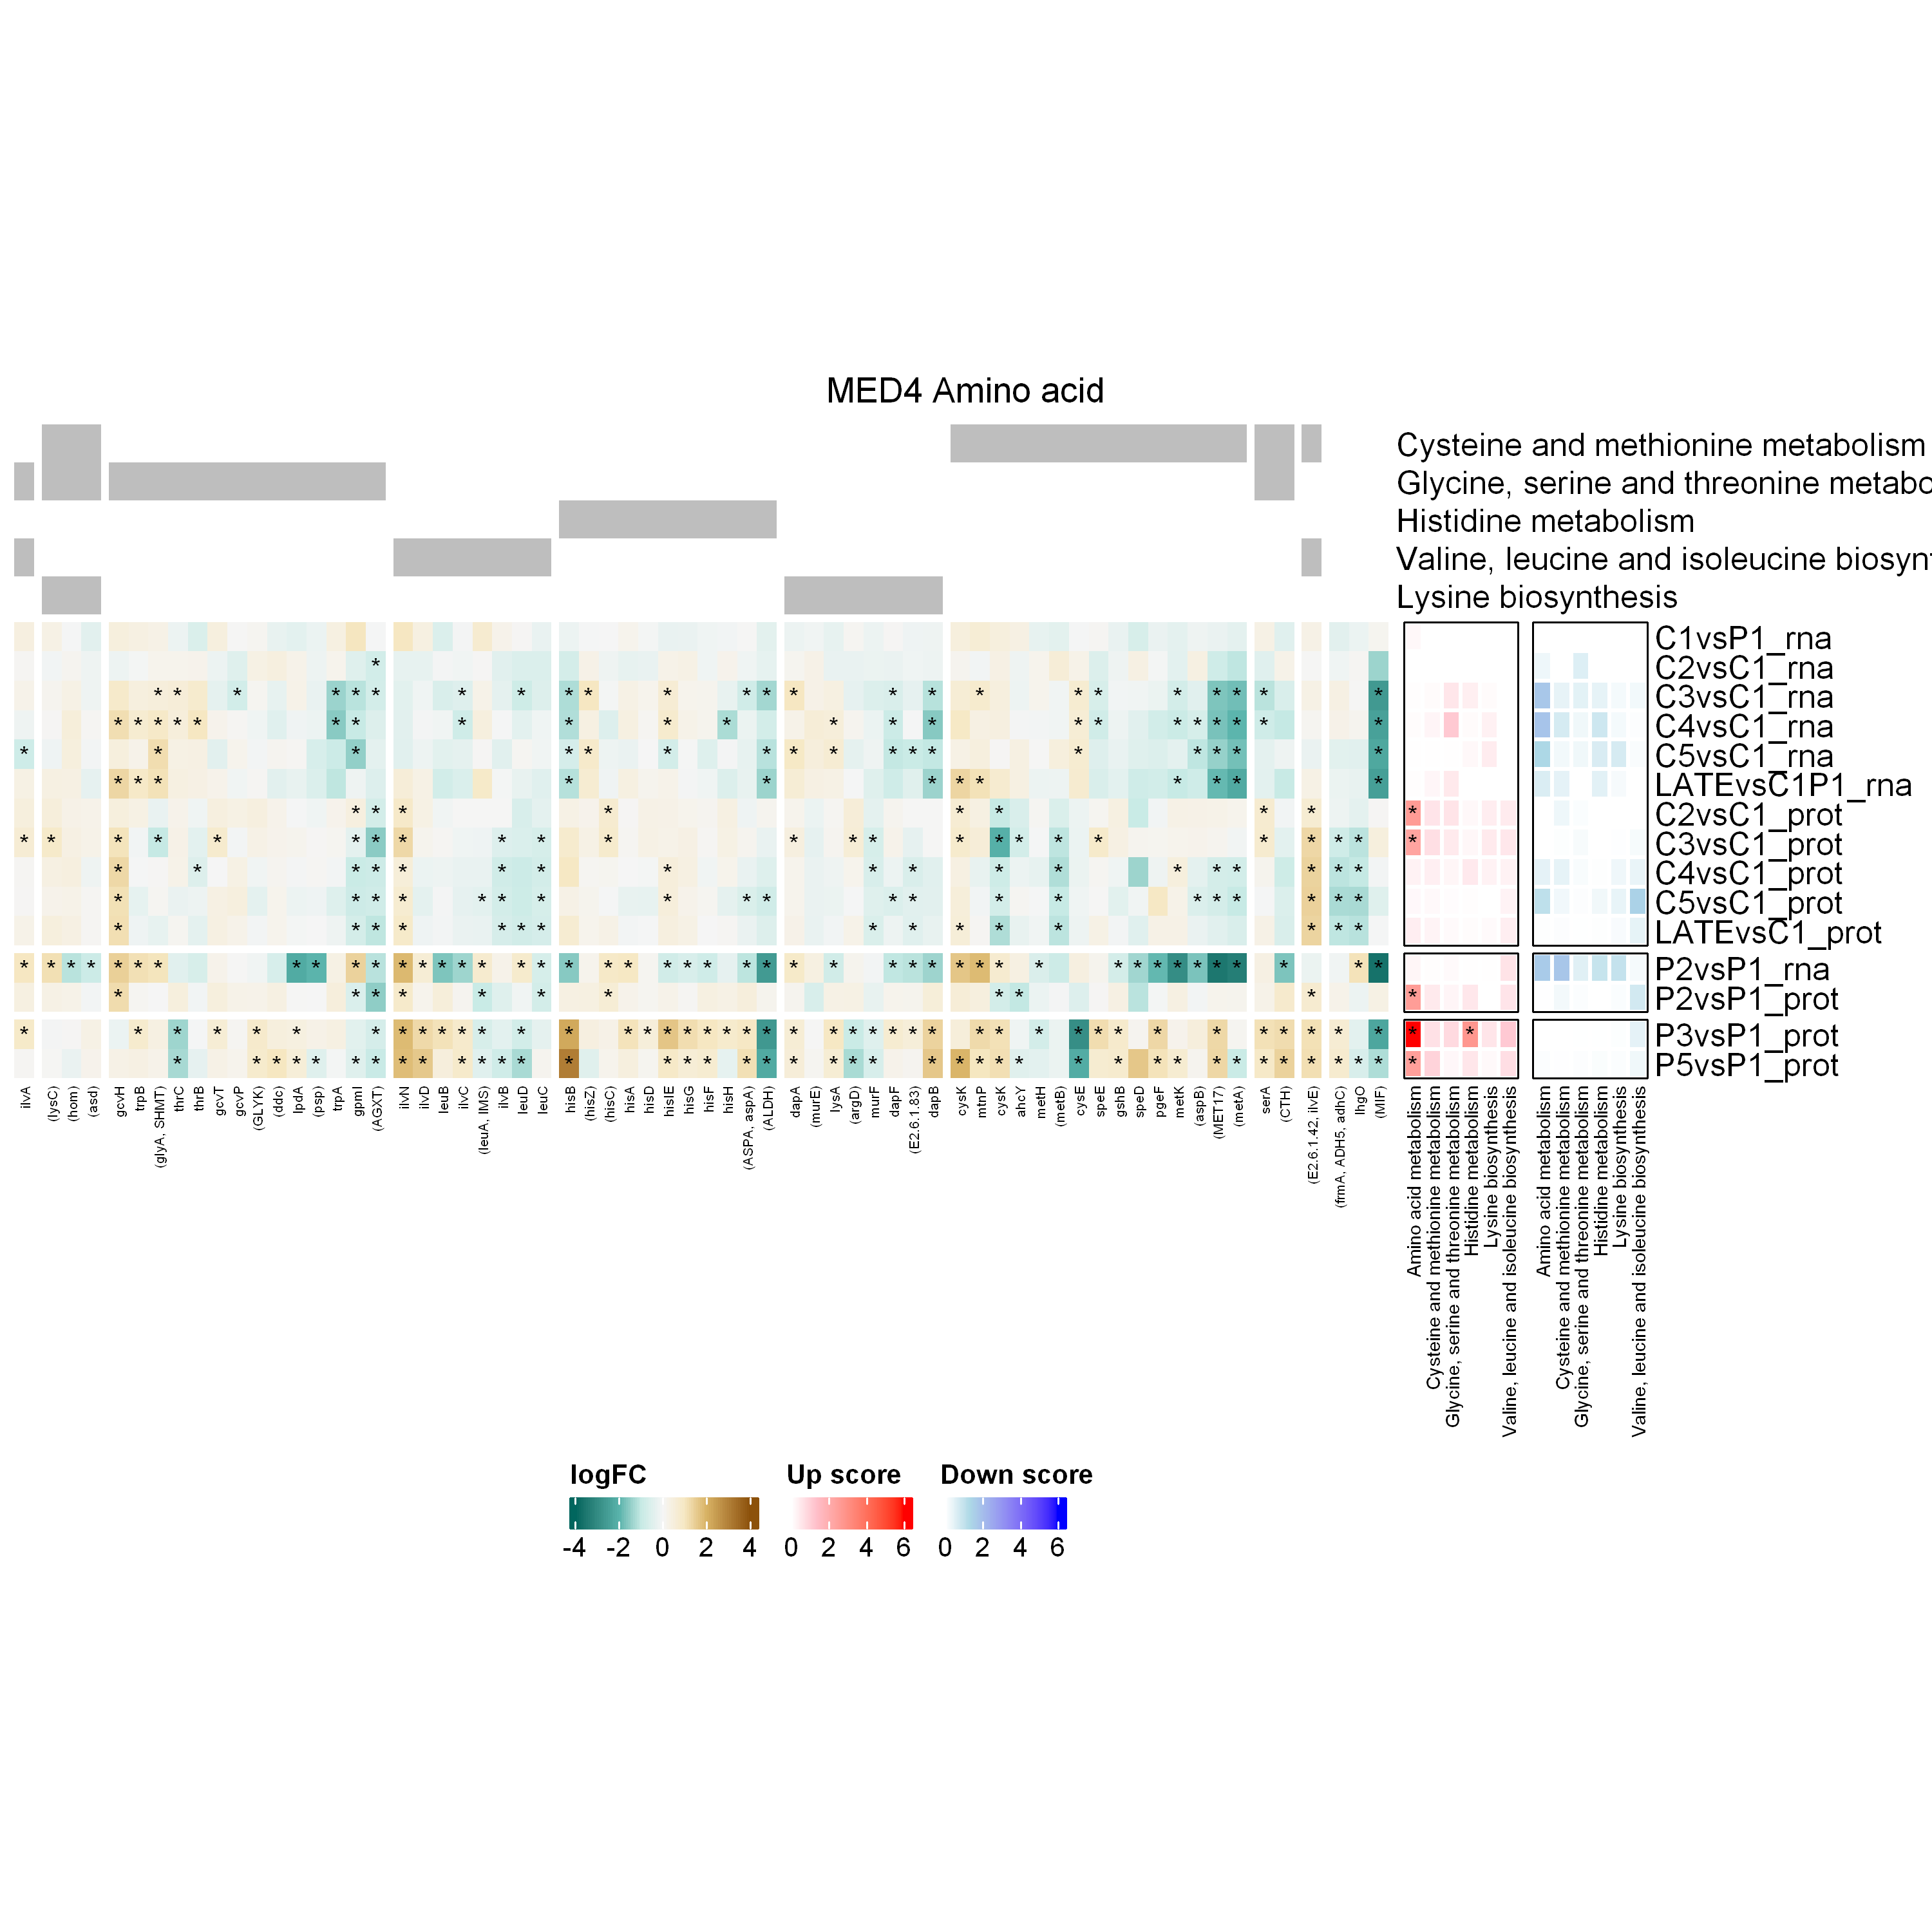

In [282]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [283]:
dput(toppaths)

structure(list(pathway = c("Amino acid metabolism", "Cysteine and methionine metabolism", 
"Glycine, serine and threonine metabolism", "Valine, leucine and isoleucine biosynthesis", 
"Lysine biosynthesis", "Histidine metabolism")), row.names = c(NA, 
-6L), class = c("tbl_df", "tbl", "data.frame"))


In [284]:
head(df_all)

contrast,gene_id,logFC,AveExpr,pvalue,padj,Assay,contrast1,Length,down,⋯,X,path_id,main,sub,module,path,pathway,ecpath,kegg_gene,prev_gene
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C2 - C1,TX50_RS01980,2.6029332,0.9167156,5.951467e-07,0.0004868287,Proteome,C2vsC1_prot,852,FALSE,⋯,549,K15578,09100 Metabolism;09130 Environmental Information Processing;09180 Brite Hierarchies,09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes,Energy;Membrane transport;Protein families: signaling and cellular processes,00910 Nitrogen metabolism [PATH:ko00910];02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],Nitrogen metabolism;ABC transporters;Transporters,"K15578 nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]","nrtC, nasD",
C2 - C1,TX50_RS05125,1.7956460,2.0464881,8.763244e-07,0.0004868287,Proteome,C2vsC1_prot,1707,FALSE,⋯,1437,K01428,09100 Metabolism;09160 Human Diseases,09104 Nucleotide metabolism;09105 Amino acid metabolism;09111 Xenobiotics biodegradation and metabolism;09171 Infectious disease: bacterial,Nucleotide;Amino acid;Xenobiotics biodegradation and;Infectious disease: bacterial,00230 Purine metabolism [PATH:ko00230];00220 Arginine biosynthesis [PATH:ko00220];00791 Atrazine degradation [PATH:ko00791];05120 Epithelial cell signaling in Helicobacter pylori infection [PATH:ko05120],Purine metabolism;Arginine biosynthesis;Atrazine degradation;Epithelial cell signaling in Helicobacter pylori infection,K01428 ureC; urease subunit alpha [EC:3.5.1.5],ureC,ureC
C2 - C1,TX50_RS09075,1.1167539,1.4678595,1.025622e-06,0.0004868287,Proteome,C2vsC1_prot,2571,FALSE,⋯,2496,K01682,09100 Metabolism,09101 Carbohydrate metabolism;09102 Energy metabolism,Carbohydrate;Energy,00020 Citrate cycle (TCA cycle) [PATH:ko00020];00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630];00640 Propanoate metabolism [PATH:ko00640];00720 Carbon fixation pathways in prokaryotes [PATH:ko00720],Citrate cycle (TCA cycle);Glyoxylate and dicarboxylate metabolism;Propanoate metabolism;Carbon fixation pathways in prokaryotes,K01682 acnB; aconitate hydratase 2 / 2-methylisocitrate dehydratase [EC:4.2.1.3 4.2.1.99],acnB,acnB
C2 - C1,TX50_RS05175,1.4380690,-0.2070244,2.486196e-06,0.0008850858,Proteome,C2vsC1_prot,753,FALSE,⋯,1455,K11962,09130 Environmental Information Processing;09180 Brite Hierarchies,09131 Membrane transport;09183 Protein families: signaling and cellular processes,Membrane transport;Protein families: signaling and cellular processes,02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],ABC transporters;Transporters,K11962 urtD; urea transport system ATP-binding protein,urtD,urtD
C2 - C1,TX50_RS08845,-0.9884268,3.7497430,3.186503e-06,0.0009075161,Proteome,C2vsC1_prot,1419,TRUE,⋯,2421,K03545,09190 Not Included in Pathway or Brite,09192 Unclassified: genetic information processing,Unclassified: genetic information processing,99975 Protein processing,Protein processing,K03545 tig; trigger factor,tig,tig
C2 - C1,TX50_RS01985,1.7087460,-0.2557767,5.226353e-06,0.0012403878,Proteome,C2vsC1_prot,441,FALSE,⋯,552,K01725,09100 Metabolism,09102 Energy metabolism,Energy,00910 Nitrogen metabolism [PATH:ko00910],Nitrogen metabolism,K01725 cynS; cyanate lyase [EC:4.2.1.104],cynS,cynS


In [285]:
write.csv(df_all, 't.csv')

In [286]:
df_all %>% 
    filter(padj < 0.05) %>% 
    mutate(direction = if_else(logFC >0 , 'UP', 'DOWN')) %>%
    filter(str_detect(contrast1, 'C1')) %>%
    select('direction', "gene_id", "gene", "product", "ecpath",
"module",  "pathway",  ) %>%
    distinct(direction, gene_id, .keep_all = TRUE) %>%
write.csv('de_genes.csv')
           


In [287]:
dput(names(df_all))

c("contrast", "gene_id", "logFC", "AveExpr", "pvalue", "padj", 
"Assay", "contrast1", "Length", "down", "up", "gene", "product", 
"protein_id", "old_locus_tag", "X", "path_id", "main", "sub", 
"module", "path", "pathway", "ecpath", "kegg_gene", "prev_gene"
)


In [288]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.1              
 [3] ComplexUpset_1.3.3          circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen